In [1]:
import velvet as vt

# general packages
import numpy as np
import pandas as pd
import torch
from scipy.sparse import issparse

# velocity packages
import scanpy as sc
import scvelo as scv
import anndata as ann

# plotting packages
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from IPython.display import clear_output

# color palette object
from colors import colorpalette as colpal

Global seed set to 0
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
from adjustText import adjust_text
from scipy.stats import binomtest
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.patheffects as path_effects

In [3]:
nmp = sc.read_h5ad('../data/nmp_data_1606.h5ad')

state_path = '../models/nmp_vf_1606_model.pt'

vt.md.Velvet.setup_anndata(nmp, x_layer='total', n_layer='new', knn_layer='knn_index')

model = vt.md.Velvet(
    nmp,
    n_latent = 50,
    linear_decoder = True,
    neighborhood_space="latent_space",
    biophysical_model = "full",
    gamma_mode = "learned",
    labelling_time = 2.0,
)

model.setup_model()

trained_state = torch.load(state_path)['model_state_dict']

model.module.load_state_dict(trained_state)

INFO     Generating sequential column names                                                                        


<All keys matched successfully>

In [5]:
model.module = model.module.to('cuda')

model.adata.obs['index'] = np.arange(model.adata.shape[0])

vt.sm.VelvetSDE.setup_anndata(
    model, 
    x_layer='total', 
    index_key='index'
)

markov = vt.sb.MarkovProcess(
    model,
    n_neighbors=10,
    use_space='latent_space',
    use_spline=True, 
    use_similarity=False
)

sde = vt.sb.SDE(
    model.module.n_latent,
    prior_vectorfield=model.module.vf,
    noise_scalar=0.1,
    device=model.device
)

sde_model = vt.sm.VelvetSDE(
    model,
    sde,
    markov,
)


sde_state_path = '../models/nmp_sde_1606_model.pt'

trained_state_sde = torch.load(sde_state_path)['model_state_dict']

sde_model.module.load_state_dict(trained_state_sde)

KNN indices for Velvet stored in .obsm['knn_index'].


<All keys matched successfully>

In [6]:
initial_cells = sde_model.adata[sde_model.adata.obs.timepoint=='D3.2']

In [7]:
trajectories, cell_ids = sde_model.simulate(
    initial_cells=initial_cells,
    n_samples_per_cell=1,
    n_steps = 100,
    t_max = 70,
    dt = 1.0,
    latent_key='X_z',
    n_chunks=10
)

avg_center, labels, centers, index = vt.cl.cluster_trajectories(trajectories, n_clusters=2)
cluster_labels = labels.cpu().numpy()

Simulating Chunk 9: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


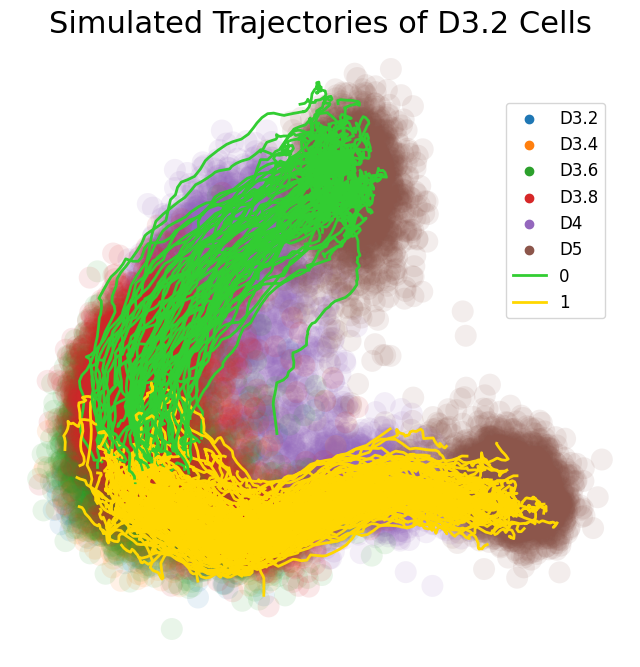

In [8]:
components=[0,1]

cmap = {1:'gold',0:'limegreen',2:'red',3:'blue'}
clmap = {1:'1',0:'0',2:'2',3:'3'}

z = model.adata.obsm['X_z']
z = torch.tensor(z, device=model.device)

pca = PCA()
z_pca = pca.fit_transform(z.detach().cpu().numpy())

t_pca = []
for traj in trajectories[:200]:
    t_pca.append(pca.transform(traj.detach().cpu().numpy()))

copy = model.adata.copy()
copy.obsm['X_vae'] = z_pca
copy.uns["velocity_params"] = {'embeddings':'vae'}
fig, ax = plt.subplots(figsize=(8,8))

scv.pl.scatter(copy, basis='vae', color='timepoint', alpha=0.1,
              ax=ax, size=1000, show=False, components=f"{components[0]+1},{components[1]+1}",
               legend_loc='right margin')

groups = []
for t, cl in zip(t_pca, cluster_labels[:200]):
    color = cmap[cl]
    if cl in groups:
        label=''
    else:
        label=clmap[cl]
        groups.append(cl)
    ax.plot(t[:,components[0]],t[:,components[1]], color=color, alpha=1, linewidth=2, label=label)
ax.set_title("Simulated Trajectories of D3.2 Cells", fontsize=22)
plt.legend(loc=(.8,.55),fontsize=12)
plt.show()

In [9]:
neur_trajectories = trajectories[labels==0]
meso_trajectories = trajectories[labels==1]

neur_subset = neur_trajectories[torch.randperm(neur_trajectories.shape[0])[:2000]]
meso_subset = meso_trajectories[torch.randperm(meso_trajectories.shape[0])[:2000]]

In [10]:
tfs = np.load('/camp/lab/briscoej/working/Rory/transcriptomics/gene_lists/confirmed_tfs.npy')
tfs = np.array(list(set(tfs).intersection(initial_cells.var_names)))

def test_simulations(
    initial_cells,
    meso_subset,
    neur_subset,
    genes=None,
    effect='max',
    return_trajectories=False,
):
    data = torch.tensor(initial_cells.layers['total'], device=model.device)
    if genes is not None:
        if type(genes)==str:
            idx = np.where(model.adata.var_names==genes)[0][0]
            if effect=='min':
                data[:,idx] = data[:,idx].min()
            elif effect=='max':
                data[:,idx] = data[:,idx].max()
        elif type(genes)==list:
            for gene in genes:
                idx = np.where(model.adata.var_names==gene)[0][0]
                if effect=='min':
                    data[:,idx] = data[:,idx].min()
                elif effect=='max':
                    data[:,idx] = data[:,idx].max()
        else:
            print("gene format not recognised")
            
    z = model.module.inference(
        data,
        torch.zeros(data.shape[0])
    )['z']
    with torch.no_grad():
        test_trajectories, test_cell_ids = sde_model.simulate(
            initial_cells=z,
            n_samples_per_cell=1,
            n_steps = 100,
            t_max = 70,
            dt = 1.0,
            latent_key='X_z',
            n_chunks=10
        )
    
    results = torch.zeros(test_trajectories.shape[0])
    for i, traj in enumerate(tqdm(test_trajectories)):
        neur_dist = (neur_subset - traj.unsqueeze(0)).norm(dim=-1).mean()
        meso_dist = (meso_subset - traj.unsqueeze(0)).norm(dim=-1).mean()
        results[i] = torch.tensor([meso_dist, neur_dist]).argmin()
    
    if return_trajectories:
        return results, test_trajectories
    else:
        return results
    
def jitter_plot(
    oe_dists, 
    tfs, 
    jitsize=0.001, 
    pvalues=None, 
    figsize=(8, 4), 
    dpi=200, 
    palette='inferno', 
    n=5, 
    show=True,
    lims=(0.50, 0.65),
    jitter_seed=0,
):
    
    oe = np.array([float(d.mean()) for d in oe_dists])

    index = np.argsort(oe)

    sorted_oe = oe[index]
    sorted_tf = np.array(tfs)[index]

    # Jitter
    np.random.seed(jitter_seed)
    jitter = np.random.uniform(-jitsize, jitsize, len(sorted_oe))

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    # Color map
    if pvalues is not None:
        sorted_pvalues = np.array(pvalues)[index]
        norm = Normalize(vmin=sorted_pvalues.min(), vmax=sorted_pvalues.max())
        cmap = cm.get_cmap(palette)
        points_colors = cmap(norm(sorted_pvalues))
        sc = ax.scatter(sorted_oe, jitter, c=points_colors)
        cbar = plt.colorbar(sc, ax=ax)
        cbar.ax.set_ylabel('Negative log p-value', rotation=270, labelpad=15)
        cbar.mappable.set_cmap(cmap)
        cbar.mappable.set_norm(norm)
    else:
        ax.scatter(sorted_oe, jitter)

    # Annotate lowest and highest values
    lowest_indices = index[:n]
    highest_indices = index[-n:]

    texts = []
    for i in range(n):
        annotation = ax.annotate(sorted_tf[i], xy=(sorted_oe[i], jitter[i]), alpha=0.5,
                                 xytext=(5, -15), textcoords='offset points', ha='right', va='bottom', fontsize=12)
        annotation.set_path_effects([path_effects.withStroke(linewidth=5, foreground='w')])
        texts.append(annotation)
        #ax.plot([oe[i], oe[i] + 5], [jitter[i], jitter[i] - 5], 'grey', linestyle='dotted', alpha=0.5, lw=1)

    for i in range(len(tfs)-1,len(tfs)-1-n, -1):
        annotation = ax.annotate(sorted_tf[i], xy=(sorted_oe[i], jitter[i]), alpha=0.5,
                                 xytext=(5, -15), textcoords='offset points', ha='left', va='top', fontsize=12)
        annotation.set_path_effects([path_effects.withStroke(linewidth=2, foreground='w')])
        texts.append(annotation)
        #ax.plot([oe[i], oe[i] + 5/72*fig.dpi], [jitter[i], jitter[i] - 5/72*fig.dpi], 'grey', linestyle='dotted', alpha=0.5, lw=1)

    adjust_text(texts)

    plt.box(False)

    plt.ylim((-1.5 * jitsize, 1.5 * jitsize))
    plt.xlim(lims)
    ax.set_yticks([])  # Remove y-ticks
    plt.xlabel("cOE: Neural Proportion", fontsize=16)

    if show:
        plt.show()
    else:
        return fig, ax

In [11]:
wts = []
for _ in range(10):
    wt_dist, wt_traj = test_simulations(
        initial_cells, 
        meso_subset, 
        neur_subset,
        return_trajectories=True
    )
    
    wts.append(float(wt_dist.mean()))

100%|██████████| 2824/2824 [00:01<00:00, 2719.08it/s]


In [12]:
oe_dists, oe_trajs = [], []
ko_dists, ko_trajs = [], []
for tf in tfs:
    oe_results = test_simulations(
        initial_cells, 
        meso_subset, 
        neur_subset, 
        genes=[tf],
        effect='max',
        return_trajectories=True
    )
    oe_dists.append(oe_results[0])
    oe_trajs.append(oe_results[1])

100%|██████████| 2824/2824 [00:01<00:00, 2726.89it/s]


100%|██████████| 2824/2824 [00:01<00:00, 2726.02it/s]


100%|██████████| 2824/2824 [00:01<00:00, 2720.78it/s]


In [13]:
pvalues = []
for dist in tqdm(oe_dists):
    k = (int(sum(dist.cpu().numpy())))
    n = len((dist.cpu().numpy()))
    pvalues.append(
        binomtest(k=k, n=n, p=np.mean(wts)).pvalue
    )
    
nlpv = -np.log(pvalues)

100%|██████████| 149/149 [00:00<00:00, 403.44it/s]


In [14]:
np.save('../data/NMP_perturb_dists_1606.npy', np.array(oe_dists))
np.save('../data/NMP_perturb_pvals_1606.npy', np.array(nlpv))

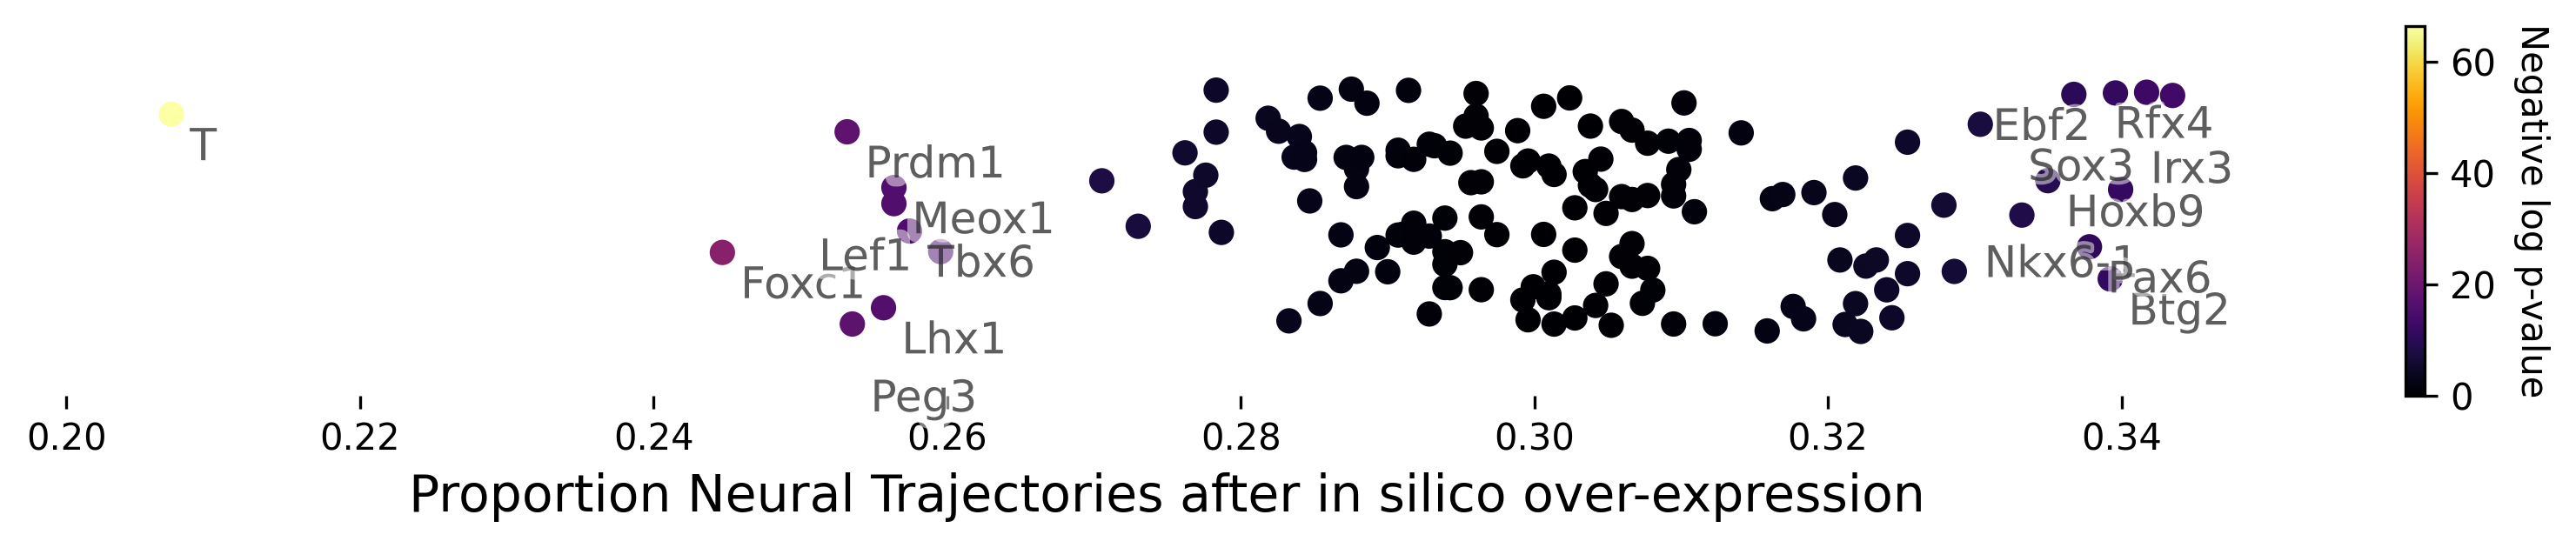

In [19]:
fig, ax = jitter_plot(oe_dists, tfs, lims=(0.2,0.35), pvalues=nlpv, n=8, dpi=300, figsize=(11,2.2), show=False, jitter_seed=6)
ax.set_xlabel("Proportion Neural Trajectories after in silico over-expression", fontsize=14)
for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')
plt.tight_layout()
plt.savefig('../figures/2.9.0_perturbation_effect.png', bbox_inches='tight')
plt.show()

In [23]:
plot_cells = sc.read_h5ad('../data/adata_nmp_decision_boundary_cells.h5ad')

In [26]:
bot_genes = ['T','Foxc1','Lef1','Prdm1','Meox1','Tbx6','Lhx1','Peg3']
top_genes = ['Irx3','Rfx4','Sox3','Hoxb9','Pax6','Btg2','Nkx6-1','Ebf2']

def pca_plot(data, pca, **kwargs):
    try:
        x = pca.transform(data)
    except ValueError:
        x = pca.transform(data.reshape(1,-1))
    plt.scatter(x[:,0],x[:,1], **kwargs)
    
def get_loadings(module):
    loadings = module.decoder.factor_regressor.fc_layers[0][0].weight
    loadings = loadings.detach().cpu().numpy()
    if module.n_batch > 1:
        loadings = loadings[:, : -module.n_batch]

    return loadings

x = plot_cells.obsm['X_z']
pca = PCA(n_components=10)
pca = pca.fit(x)

z_mix = plot_cells[plot_cells.obs.fate_description=='Mixed'].obsm['X_z']
z_mes = plot_cells[plot_cells.obs.fate_description=='Mesoderm'].obsm['X_z']
z_neu = plot_cells[plot_cells.obs.fate_description=='Neural'].obsm['X_z']

contributions = pca.components_.T
vae_loadings = get_loadings(model.module)
full_contributions = (vae_loadings @ contributions)


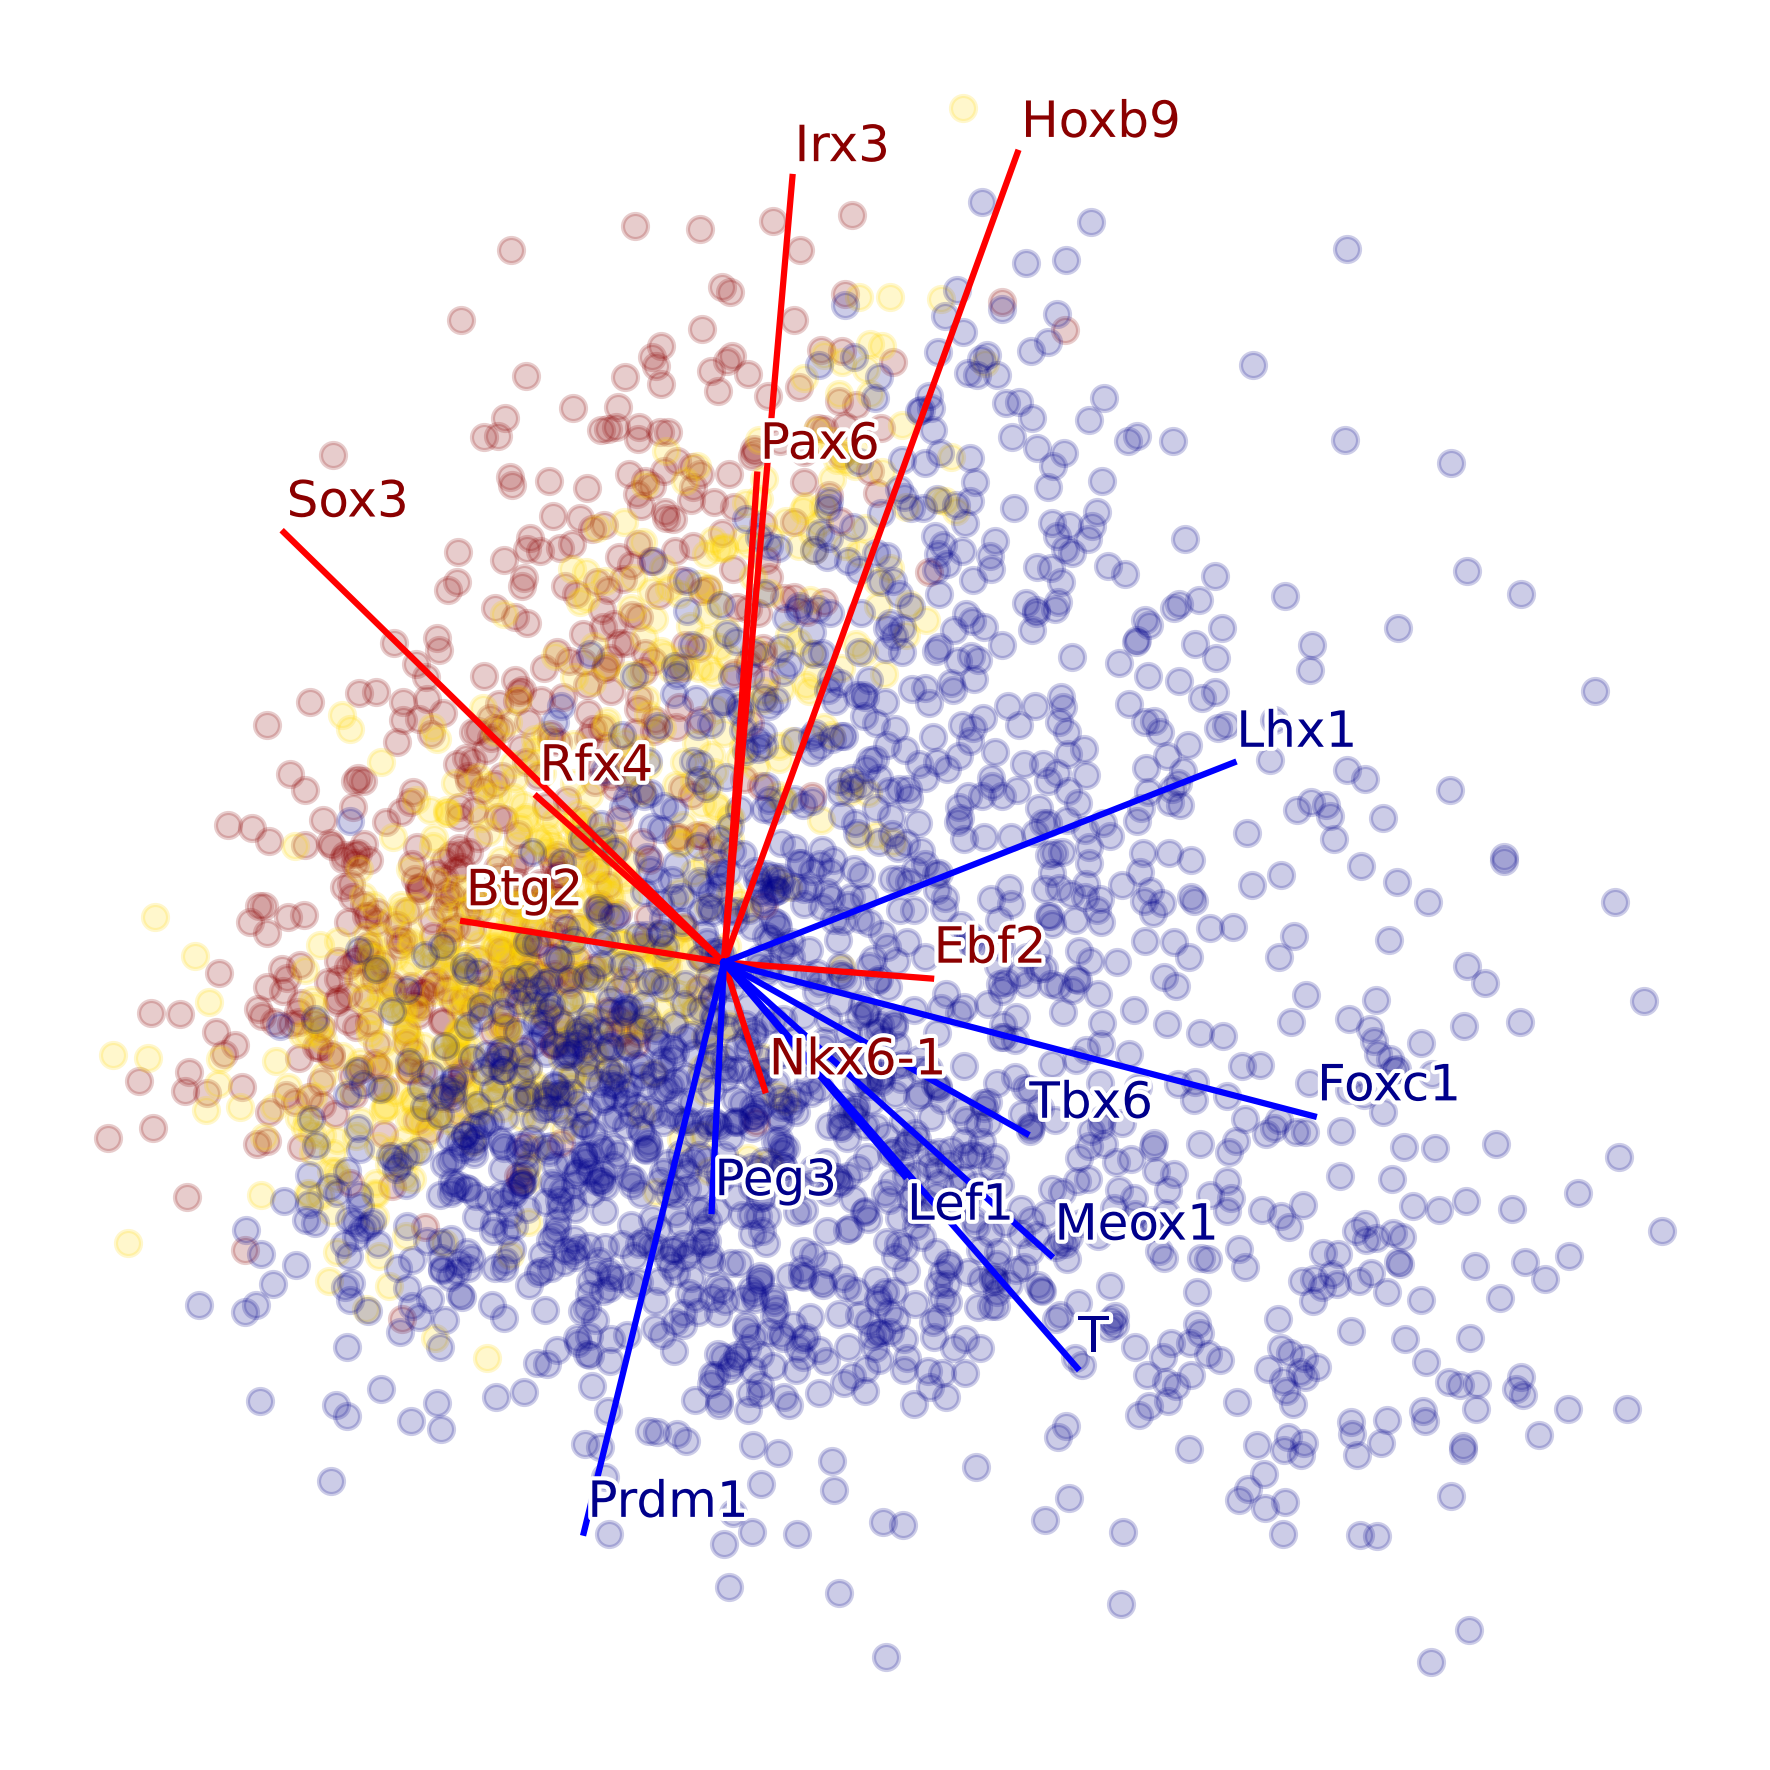

In [27]:
from adjustText import adjust_text
import matplotlib.patheffects as path_effects


plt.figure(figsize=(6,6), dpi=300)
pca_plot(z_neu, pca, color='darkred', alpha=0.2)
pca_plot(z_mix, pca, color='gold', alpha=0.2)
pca_plot(z_mes, pca, color='darkblue', alpha=0.2)

scale=15
texts = []
for gene in top_genes:
    i = np.where(plot_cells.var_names==gene)[0][0]
    plt.plot([0, scale*full_contributions[i][0]],[0, scale*full_contributions[i][1]], color='red')
    ax = plt.gca()
    text = ax.text(
        scale * full_contributions[i][0],
        scale * full_contributions[i][1], model.adata.var_names[i], fontsize=12, color='darkred'
    )
    text.set_path_effects([path_effects.withStroke(linewidth=2, foreground='w')])
    texts.append(text)
    
for gene in bot_genes:
    i = np.where(plot_cells.var_names==gene)[0][0]
    plt.plot([0, scale*full_contributions[i][0]],[0, scale*full_contributions[i][1]], color='blue')
    ax = plt.gca()
    text = ax.text(
        scale * full_contributions[i][0],
        scale * full_contributions[i][1], model.adata.var_names[i], fontsize=12, color='darkblue'
    )
    text.set_path_effects([path_effects.withStroke(linewidth=2, foreground='w')])
    texts.append(text)


adjust_text(texts)
    
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks([])
plt.yticks([])

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')
plt.tight_layout()
plt.savefig('../figures/2.9.1_decision_genes_plot.png', bbox_inches='tight')
plt.show()